# GraphSLAM with Ultrasonic Sensor and Dead Reckoning

### Introduction
In this notebook, we will implement a Simultaneous Localization and Mapping pipeline on previously saved ultrasonic distance measurements of the surroundings of a car that is moving around using a motion model to update its position (which is known as dead reckoning). We will perform the following tasks:

1. Load and plot the scanned points and car's positions from a file.
2. Cluster them to identify landmarks.
3. Solve the correspondence problem to match landmarks between the car's readings from various positions.
4. As a demo to understand how SLAM works, we will transform matched landmarks to align with each other, then use the transformation matrix to update the car's positions.
5. Finally we will use SLAM to estimate the correct positions of the car as well as the landmarks.

### Visualize Environment and Data

Let's see an image of the environment that the car is in.

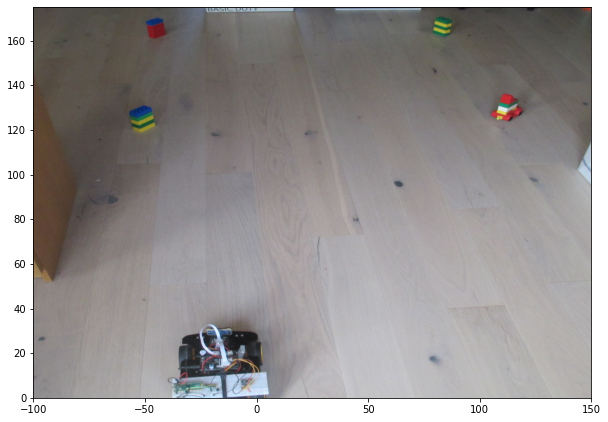

In [93]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load the environment image
img = mpimg.imread("../../images/robot_env.JPG") 
img = np.rot90(img, 2) # rotate 180 degrees 
img = np.fliplr(img)

plt.figure(figsize=(10,8))
ax = plt.gca()

# Your SLAM coordinate system is 0–300 cm
ax.set_xlim([-100, 150])
ax.set_ylim([0, 175])

# Draw the image stretched to the 0–300 cm coordinate frame
ax.imshow(img, extent=[-300+60+75, 300-155+75, 0-10, 190], origin='lower')
plt.show()

The car drives almost within the square bordered by the 4 lego blocks. I purposefully kept some clutter around so that we can get a realistic environment and possibly deal with some noisy readings.

Let's load the previously saved sensor and position data from the car.

In [94]:
'''
Load the sense/move data from car. This includes scans from ultrasonic sensor
and etimates of the way points that the car drove through.
'''

import json
import util

f = open("navigate.json", "r")
readings = json.load(f)
print(len(readings))
f.close()

30


In [95]:
print(readings[0].keys())

dict_keys(['car_x', 'car_y', 'car_heading', 'scan_points', 'xfm_scan_points'])


In [96]:
print("car_x: ", readings[0]['car_x'])
print("car_y: ", readings[0]['car_y'])
print("car_heading: ", readings[0]['car_heading'])
print("scan_points: ", len(readings[0]['scan_points']), readings[0]['scan_points'][:5])
print("xfm_scan_points: ", len(readings[0]['xfm_scan_points']), readings[0]['xfm_scan_points'][:5])

car_x:  0.0
car_y:  0.0
car_heading:  1.5707963267948966
scan_points:  180 [[78, 1], [77, 2], [77, 4], [78, 5], [78, 6]]
xfm_scan_points:  180 [[78.0, 1.0], [77.0, 2.0], [77.0, 4.0], [78.0, 5.0], [78.0, 6.0]]


Each line in the readings file is a dict which contains the car's current location, heading, the 180 degree ultrasonic scan from the current location. Since the scan is relative to the car's current position, we have to transform the scanned points to get their values relative to the car's starting position, which are contained in xfm_scan_points.

We will only read the even numbered entries in the readings file, as the odd numbered entries are related to path/searh (as shown below), which we will ignore at this time.

In [97]:
print(readings[1].keys())

dict_keys(['orig_path', 'modified_path', 'converted_path'])


Next let's visualize the ultrasonic scans and car's positions. We will overlay this data over the environment to get a feel for it.

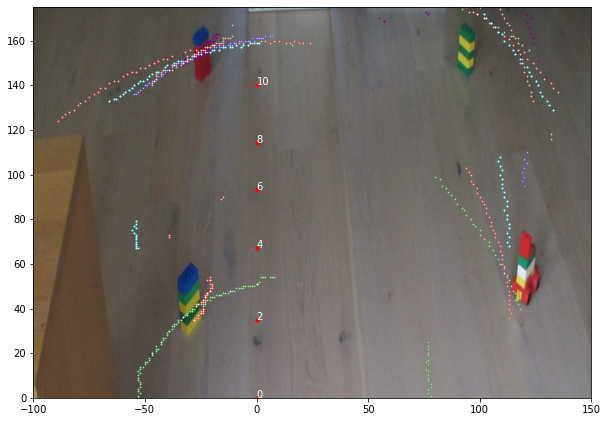

In [98]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

# Load the environment image
img = mpimg.imread("../../images/robot_env.JPG") 
img = np.rot90(img, 2) # rotate 180 degrees 
img = np.fliplr(img)

plt.figure(figsize=(10,8))
ax = plt.gca()

# Your SLAM coordinate system is 0–300 cm
ax.set_xlim([-100, 150])
ax.set_ylim([0, 175])

# Draw the image stretched to the 0–300 cm coordinate frame
ax.imshow(img, extent=[-300+90+75, 300-155+75, 0-320, 300-80], origin='lower')

p = plt.subplot(111)

clusters_to_match = dict()
car_pos = dict()
all_scan_points = []

def plot_readings(num_readings=0):
    colors = ['green', 'red', 'cyan', 'blue', 'brown', 'purple', 'yellow', 'orange', 'silver', 'pink']
    color_count = 0
    prev_points = []
    
    for i in range(len(readings)):
        d = readings[i]
        if 'car_x' not in d:
            continue
        
        x = d['car_x']
        y = d['car_y']
        heading = d['car_heading']
        
        a = np.array(d['scan_points'])
        a = util.transform(a, heading, x, y)

        all_scan_points.append([[a[i][0] + 300, a[i][1]] for i in range(len(a))])

        # Plot scan points on top of the background image
        p.scatter(a[:,0], a[:,1], s=1, color=colors[color_count%10])

        # Plot car position
        p.scatter(x, y, s=10, color="red")
        plt.text(x, y, i, fontsize=10, color="white")

        if len(prev_points) > 0:
            p.scatter(prev_points[0], prev_points[1], s=1, alpha=0.5, color="white")

        prev_points = [a[:,0], a[:,1]]
        color_count += 1
        
        if num_readings > 0 and color_count == num_readings:
            break

plot_readings(6)
plt.show()


This plot shows the first few readings. The red dots with white numbers are the poses of the car. The various colored lines are the ultrasonic measurements, as the sonar scanned the environment from each of the car's poses.

### Identifying Landmarks via Clustering

Now let's create a function to cluster these scanned points. Our algorithm simply goes point by point, if the next point is within a certain distance threshold of the previous point, it is considered as part of the same landmark, otherwise it is considered start of a new landmark.

In [99]:
'''
Function to identify landmarks by clustering scanned points.
The dist parameter defines a threshold distance within which any point is 
considered part of the current cluster, and any point that lies beyond that
starts a new cluster. 
'''
def cluster_scan_points2(pts, dist):
    clusters = []
    cluster = []
    
    prev_p = []
    for p in pts:
        if len(prev_p) != 0:
            manh_dist = abs(p[0] - prev_p[0]) + abs(p[1] - prev_p[1])
            if manh_dist >= dist:
                clusters.append(cluster.copy())
                cluster.clear()
        
        cluster.append(p)
        prev_p = p
    
    clusters.append(cluster) # add the final cluster of points
    return clusters

pts = [[1,1], [1,2], [1,3], [1,4], [10,1], [10,3], [10,4]]
clusters = cluster_scan_points2(pts, 2)
print(clusters)

'''
This is another implenentation of clustering of scan points using DBSCAN
'''
import pandas as pd
from sklearn.cluster import DBSCAN

def cluster_scan_points(pts, dist):

    df = pd.DataFrame(pts)
    df.columns = ['x', 'y']
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=dist, min_samples=1)
    df['cluster'] = dbscan.fit_predict(pts) #df[['x', 'y']])
    
    # Group by the 'cluster' column
    grouped = df.groupby('cluster')
    
    # Create a dictionary to store lists of points per cluster
    clusters = {cluster: group[['x', 'y']].values.tolist() for cluster, group in grouped}
    
    #print(clusters)
    return list(clusters.values())

pts = [[1,1], [1,2], [1,3], [1,4], [4,1], [4,3], [4,4]]
print(cluster_scan_points(pts, 2))

[[[1, 1], [1, 2], [1, 3], [1, 4]], [[10, 1]], [[10, 3], [10, 4]]]
[[[1, 1], [1, 2], [1, 3], [1, 4]], [[4, 1], [4, 3], [4, 4]]]


Now we will create the plot_landmarks() function to use one of the above clustering functions and label the identified landmarks.

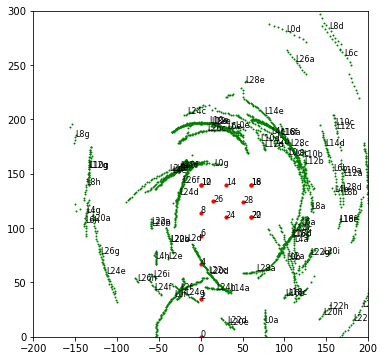

In [107]:
'''
Plot the scanned points as landmarks, as well as car's positions
'''
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

def distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


plt.figure(figsize = (6,6))
ax = plt.gca()
p = plt.subplot(111)

ax.set_xlim([-200, 200])
ax.set_ylim([0, 300])

clusters_to_match = dict()
#cluster_mid_points = dict()

car_pos = dict()
all_scan_points = []

def plot_landmarks(create_clusters=True):
    colors = ['green', 'red', 'black', 'cyan', 'yellow', 'brown', 'purple', 'orange']
    color_count = 0
    prev_points = []
    
    for i in range(len(readings)):
        d = readings[i]
        
        if 'car_x' not in d:
            continue
        
        #if i not in [24, 26]:
        #    continue
        
        x = d['car_x']
        y = d['car_y']
        heading = d['car_heading']
        
        a = np.array(d['scan_points'])

        a = util.transform(a, heading, x, y)
        
        all_scan_points.append([[a[i][0]+300, a[i][1]] for i in range(len(a))])
        
        p.scatter(a[:,0], a[:,1], s=1, color=colors[0], clip_on=True) #color_count])
        
        if create_clusters:
            clusters = cluster_scan_points(a, 15)
            idx = ord('a')
            curr_clusters = dict()
            for c in clusters:
                mid = int(len(c)/2)
                ax.text(c[mid][0], c[mid][1], "L" + str(i) + chr(idx), fontsize=8, clip_on=True)
                dist = distance(c[mid], [x,y])
                curr_clusters[chr(idx)] = {'points': c, 'mid': c[mid], 'size': len(c), 'dist': dist}
                idx += 1
            
            clusters_to_match[i] = curr_clusters
            car_pos[i] = [x,y]
        
        ax.scatter(x, y, s=10, color="red") #color_count])
        ax.text(x, y, i, fontsize=8) #, transform=ax.transAxes)
        
        #if len(prev_points) > 0:
        #    p.scatter(prev_points[0], prev_points[1], s=1, alpha=0.5, color="white")
        
        prev_points = [a[:,0], a[:,1]]
        color_count += 1

plot_landmarks(create_clusters=True)
plt.show()

Each landmark's mid-point is labelled as L<number><letter>. L just identifies that it is a landmark. The number corresponds to the car's position (0, 2, 4, ..., 28) and identifies which position was this scan taken from. The letter identifies each separate landmark uniquely within a scan from a particular position.
    
This is a noisy map, as we can see that the car seemed to have travelled through some obstacles (e.g. the red dots 2 and 4). However, we can see some dark cluster of points created by overlapping scans. These seem to be good indicators of actual obstacles, so we can treat these as landmarks. Let's try to create a heat map to overlay the scans and filter out the points that fall below a threshold in subsequent scans.

In [8]:
'''
Define function to create and plot a heatmap of scanned points. This function
is called after a number of scans have been taken using ultrasonic sensor of 
the car or some other distance point sensor. Then it keeps any points that 
average above the threshold and discards other poitns as false positives.
'''
def get_heat_map(arr, threshold=0.3, size=[5,5]):
    heat_map = np.zeros(size)
    for points in arr:
        for point in points:
            x, y = point
            #print("points = ", r, c)
            if(y <= size[0] and x <= size[1]):
                heat_map[int(y), int(x)] += 1
    
    heat_map /= len(arr)
    #x, y = np.where(heat_map > threshold)
    #plt.scatter(x, y, s=1) #, alpha=heat_map)
    return heat_map

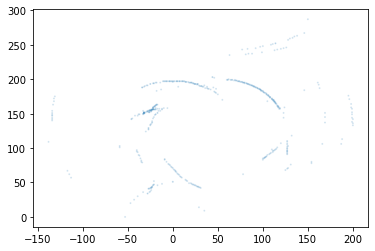

In [9]:
'''
Display a heat map of scanned points
'''
heat_map = get_heat_map(all_scan_points, threshold=0.1, size=[300,600])
y, x = np.where(heat_map > 0.1)
plt.scatter(x-300, y, s=1, alpha=heat_map[y,x])
plt.show()

It cleaned up quite some points, eventhough this method doesn't get all the clustered points and there is still some noise. This needs a bit more work. For now we will not worry about it and move on since our main focus is to implement SLAM and we have quite a few landmarks that we can match.

### Matching Landmarks

To implement SLAM, we need to identify a landmark that we have seen previously. This is called the Correspondence Problem. Here we will use a very basic method. Let's implement a function that takes 2 sets of scans from two different positions, then compares the clusters within those 2 sets and returns the pairs of clusters that match closely given their mutual distance and size.

In [10]:
import itertools

def all_closest_pairs(c1, c2, dist_thresh, size_thresh):
    pairs = []
    used_points_set1 = list() #set()
    used_points_set2 = list() #set()
    
    for k1, k2 in itertools.product(c1, c2):
        #if k1 not in used_points_set1 and k2 not in used_points_set2:
        dist = distance(c1[k1]['mid'], c2[k2]['mid'])
        size_diff = abs(c1[k1]['size'] - c2[k2]['size'])
        if dist <= dist_thresh and size_diff <= size_thresh:
            pairs.append((dist, abs(c1[k1]['size'] - c2[k2]['size']), (k1, k2))) #, (c1[k1], c2[k2])])
            
    pairs.sort(key=lambda x: x[0])
    closest_pairs = dict()
    for _, _, pair in pairs:
        k1, k2 = pair
        if k1 not in used_points_set1 and k2 not in used_points_set2:
            closest_pairs[k1] = k2
            used_points_set1.append(k1) #add(point1)
            used_points_set2.append(k2) #add(point2)
    
    return closest_pairs

# Example usage
set1 = clusters_to_match[24]
set2 = clusters_to_match[26]
dist_thresh = 25 # cm
size_thresh = 15 # number of points in the cluster

closest_pairs = all_closest_pairs(set1, set2, dist_thresh, size_thresh)
print("Pairs of points sorted by closeness without repetition and within threshold:")
for k1 in closest_pairs:
    k2 = closest_pairs[k1]
    print(k1, k2, set1[k1]['mid'], set2[k2]['mid'])

Pairs of points sorted by closeness without repetition and within threshold:
d f [-26.000000000000007, 131.0] [-21.517504035171417, 141.95931261501968]
f i [-54.999999999999986, 43.999999999999986] [-56.37567580549275, 55.90172805194486]
e g [-113.0, 57.99999999999997] [-120.30671890796913, 76.21974291140657]


As a test, we picked scan number 24 and 26. There are 3 pairs of clusters that match between those scans that are listed above: (d, f), (f, i), (e, g). Let's draw these out and see how well they match.

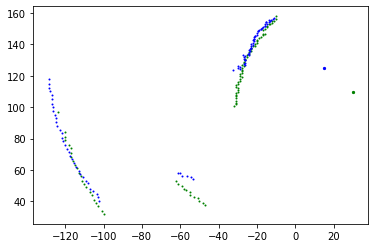

In [11]:
L1 = [np.array(clusters_to_match[24]['d']['points'])]
L2 = [np.array(clusters_to_match[26]['f']['points'])]

L1.append(np.array(clusters_to_match[24]['f']['points']))
L2.append(np.array(clusters_to_match[26]['i']['points']))
    
L1.append(np.array(clusters_to_match[24]['e']['points']))
L2.append(np.array(clusters_to_match[26]['g']['points']))

L1_mid = [np.array(clusters_to_match[24]['d']['mid'])]
L2_mid = [np.array(clusters_to_match[26]['f']['mid'])]

L1_mid.append(np.array(clusters_to_match[24]['f']['mid']))
L2_mid.append(np.array(clusters_to_match[26]['i']['mid']))

L1_mid.append(np.array(clusters_to_match[24]['e']['mid']))
L2_mid.append(np.array(clusters_to_match[26]['g']['mid']))

car1 = car_pos[24]
car2 = car_pos[26]

for a,b in zip(L1, L2): 
    plt.scatter(a[:,0], a[:,1], s=1, color='green')
    plt.scatter(b[:,0], b[:,1], s=1, color='blue')
    
plt.scatter(car1[0], car1[1], s=5, color='green')
plt.scatter(car2[0], car2[1], s=5, color='blue')

The above plot shows the landmarks as well as the car's positions (shown as dots), color coded to match. Green is position 24, and blue is 25.

### Use Spatial Transformation to Update Estimates

To get an intuition of what SLAM does, imagine that you can select all the blue scan points, then move them with your mouse to best align them with the green points. As you imagine selecting and moving them, imagine that the blue dot indicating the corresponding car's position is somehow connected with those points and also moves along with. Once you drop the scan points at the best alignment, the car's blue dot also drops accordingly. This will be the new estimate of the car's position based on aligning the landmark points.

The following code does exactly that. First, we need to define a function that calculates the transformation from the blue scan points to the green ones and gives us a rotation matrix and translation vector.

In [12]:
'''
Find the best tranlation of a set of source points to a target. This is used
to move one set of scan points taken from one location to another matched set 
of scan points taken from a different location. Then this movement/translation
is used to determine how much the car's position should be moved. This is used
as a demonstration of what SLAM does. 
'''

import numpy as np

def rigid_body_transformation(points_A, points_B):
    """
    Calculate the rigid body transformation (rotation and translation)
    to align points_A with points_B.

    Args:
        points_A: Nx3 array of points (source).
        points_B: Nx3 array of points (target).

    Returns:
        R: 3x3 rotation matrix.
        t: 3x1 translation vector.
    """
    assert points_A.shape == points_B.shape, "Point sets must have the same shape!"

    # Calculate centroids
    centroid_A = np.mean(points_A, axis=0)
    centroid_B = np.mean(points_B, axis=0)

    # Subtract centroids (center the points)
    centered_A = points_A - centroid_A
    centered_B = points_B - centroid_B

    # Compute covariance matrix
    H = np.dot(centered_A.T, centered_B)

    # Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Ensure a proper rotation (det(R) = 1)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Compute translation vector
    t = centroid_B - np.dot(R, centroid_A)

    return R, t

Now we will use this function to transform the blue scan points to the green ones.

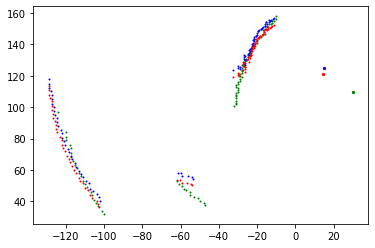

In [17]:
weights = []
for l in L1:
    weights.append(len(l))
    
s = sum(weights)
weights = [w/s for w in weights]

for a,b in zip(L1, L2): 
    plt.scatter(a[:,0], a[:,1], s=1, color='green')
    plt.scatter(b[:,0], b[:,1], s=1, color='blue')
    
plt.scatter(car1[0], car1[1], s=5, color='green')
plt.scatter(car2[0], car2[1], s=5, color='blue')

t = []
r = []
for p, q, w in zip(L1_mid, L2_mid, weights):
    rot, translate = rigid_body_transformation(q.reshape(1,2), p.reshape(1,2))
    t.append(w * translate)
    r.append(rot)
    
translate = np.mean(t, axis=0)
rotate = np.mean(r, axis=0)

for b in L2:
    b_xfrm = np.dot(b, rotate) + translate
    plt.scatter(b_xfrm[:, 0], b_xfrm[:, 1], s=1, color="red")

car2_xfrm = np.dot(car2, rotate) + translate #translate_points(car2, translate)

car2_filtered = 0.2 * np.array(car2) + 0.8 * car2_xfrm

plt.scatter(car2_filtered[0], car2_filtered[1], s=5, color='red')
plt.show()

The red points above indicate the transformation of the blue points to match the green points (it is mostly a translation at this point, since we only considered the mid points of each cluster. We also calculated weights of each cluster's translation, based on the length of the cluster (basiclly a cluster of fewer points will contribute less weight). Finally, we apply the weighted transformation to the car's position to get an updated estimate (shown as the red dot). This is essentially what we want to do with SLAM. In the second last line in the code above, we gave a smaller weight to the car's position (0.2), and higher weight to the landmark (0.8). This corresponds to the sigma we use for movement vs measurement in SLAM.

### Use GraphSLAM to Update Estimates 

Next, we will calculate the estimates of the car's positions and the landmarks using GraphSLAM.

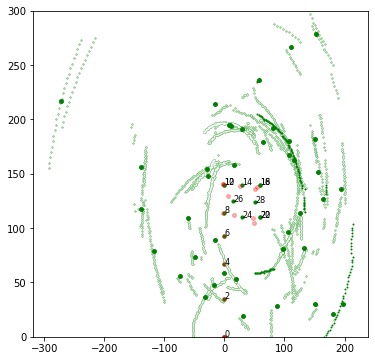

In [15]:
from SLAM import SLAM

slam = SLAM(dist_thresh=40, size_thresh=15)

car_init = list(car_pos.values())[0]
slam.initSLAM(np.array(car_init))

measurements = dict()
time_step = 0 # keep track of car's moves

car_est = [car_init[0], car_init[1]]
prev_car_pos = car_init
#print("initial pos: ", car_est)
for k1 in clusters_to_match:                    
    
    car_x, car_y = slam.sense(clusters_to_match[k1])
    car_est.append(car_x)
    car_est.append(car_y)
    #print(k1)
    #print("after sense: ", car_est[-2:])
    
    if time_step > 0:
        car_motion = np.array(car_pos[k1]) - prev_car_pos
        new_car_pos = [car_est[-2], car_est[-1]] + car_motion
        car_x, car_y = slam.move(motion=new_car_pos, motion_noise=0.05)
        prev_car_pos = car_pos[k1]
        #print("after move: ", [car_x, car_y])
    
    time_step += 1

plt.figure(figsize = (6,6))
ax = plt.gca()
ax.set_ylim([0, 300])
p = plt.subplot(111)

plot_landmarks(create_clusters=False)

# plot estimated landmarks
p.scatter(slam.mu.value[2::2], slam.mu.value[3::2], s=15, color='green')

# plot estimated car pos
p.scatter(car_est[::2], car_est[1::2], s=15, color='red', alpha=0.3)
plt.show()

Here, we can see the car's original positions as the green dots with numbers, the green dots without numbers are the updated estimates of the landmarks (scan points) after matching them and running through SLAM updates, the red dots are the updated estimates of the car's position at each time step. 

### Conclusion and Next Steps

There are still some noisy scans which we didn't put much effort to filter out at this time (that would be an interesting enhancement idea). Nevertheless, we got a working pipeline to run GraphSLAM on real data collected from the car! We started with real data collected from the car using dead reckonning to determine its position and ultrasonic distance sensor of its surroundings, visualized the data and environment, identified landmarks, tackled the correspondence problem and saw one way to solve it, updated the estimates of landmarks and car's position using sptial transformation, updated estimates using GraphSLAM.

At this time, the SLAM implementation is not provided in this repo, as this code is part of a graded course. Students can use their own GraphSLAM implementation that they implement for the simulated projects. You will need to modify it to solve the landmark correspondence problem. You can use the matching function provided above (all_closest_pairs) for this purpose and as a guide. Alternately, you can also experiment with the Iterative Closest Point algorithm to match landmarks (that will be an interesting exercise!).